<a href="https://colab.research.google.com/github/mofahad/NCBI_Dataset_Custom_NER_-SPACY/blob/main/CustomNERwithSpacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m spacy download en_core_web_md

In [22]:
#Import all required libraries
import spacy
import random
import time
import numpy as np
from spacy.util import minibatch, compounding

import en_core_web_md

#nlp = en_core_web_md.load()
#spacy.load('en_core_web_md')
import sys
from spacy import displacy
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

We have to convert tsv file to the format accepted by spaCy for training.
One of the format supported by spaCy is:
TRAIN_DATA = [[(Sentence, {entities: [(start, end, label)]], ...]

In [23]:
def load_data_spacy(file_path):
    ''' Converts data from:
    word \t label \n word \t label \n \n word \t label
    to: sentence, {entities : [(start, end, label), (stard, end, label)]}
    '''
    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split("\t")
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            if(label != 'O'):
                label = line[1]+"_Disease"     # the .txt is formatted: label \t word, label[0:2] = label_type
            #label_type = line[0][0] # beginning of annotations - "B", intermediate - "I"
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space
           
            if label == 'I_Disease' :  # if at the end of an annotation
                entities.append(( start,end-1, label))  # append the annotation
                              
            if label == 'B_Disease':                         # if beginning new annotation
                entities.append(( start,end-1, label))# start annotation at beginning of word
                
           
           
            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)
 
        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels   

Let us convert our train data,test data and validation data to spaCy format

In [24]:
TRAIN_DATA, LABELS = load_data_spacy('/content/drive/MyDrive/NCBI-disease/train.tsv')
print(TRAIN_DATA)
print(len(TRAIN_DATA))
TEST_DATA, _ = load_data_spacy("/content/drive/MyDrive/NCBI-disease/test.tsv")
print(len(TEST_DATA))
VALID_DATA, _ = load_data_spacy("/content/drive/MyDrive/NCBI-disease/train_dev.tsv")
print(len(VALID_DATA))


[['Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .', {'entities': [(44, 55, 'B_Disease'), (56, 65, 'I_Disease'), (66, 70, 'I_Disease'), (71, 77, 'I_Disease')]}], ['The adenomatous polyposis coli ( APC ) tumour - suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta ( GSK - 3beta ) , axin / conductin and betacatenin .', {'entities': [(4, 15, 'B_Disease'), (16, 25, 'I_Disease'), (26, 30, 'I_Disease'), (31, 32, 'I_Disease'), (33, 36, 'I_Disease'), (37, 38, 'I_Disease'), (39, 45, 'I_Disease')]}], ['In colon carcinoma cells , loss of APC leads to the accumulation of betacatenin in the nucleus , where it binds to and activates the Tcf - 4 transcription factor ( reviewed in [ 1 ] [ 2 ] ) .', {'entities': [(3, 8, 'B_Disease'), (9, 18, 'I_Disease')]}], ['Like APC , APC2 regulates the formation of active betacatenin - Tcf complexes , as demonstrated using transient transcriptional activation assa

Let us define methods to compute Precision,Recall and F1-score

Model evaluation -> Dataset( train/test/validation)

TP = Word predicted as either I_Disease or B_Disease and present in the data(train/test/validation) as as either I_Disease or B_Disease
FP = Word predicted as either I_Disease or B_Disease and not present in the data (train/test/validation)  as as either I_Disease or B_Disease
FN = Word present in the data(train/test/validation) data as as either I_Disease or B_Disease but not predicted as as either I_Disease or B_Disease

Metrics:
Precision = TP/(TP+FP )
Recall = TP/(TP+FN)
F1-score = 2 * Precision* Recall/ (Precision+Recall)

In [25]:
[x for x in TRAIN_DATA[0:100]]

[['Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .',
  {'entities': [(44, 55, 'B_Disease'),
    (56, 65, 'I_Disease'),
    (66, 70, 'I_Disease'),
    (71, 77, 'I_Disease')]}],
 ['The adenomatous polyposis coli ( APC ) tumour - suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta ( GSK - 3beta ) , axin / conductin and betacatenin .',
  {'entities': [(4, 15, 'B_Disease'),
    (16, 25, 'I_Disease'),
    (26, 30, 'I_Disease'),
    (31, 32, 'I_Disease'),
    (33, 36, 'I_Disease'),
    (37, 38, 'I_Disease'),
    (39, 45, 'I_Disease')]}],
 ['In colon carcinoma cells , loss of APC leads to the accumulation of betacatenin in the nucleus , where it binds to and activates the Tcf - 4 transcription factor ( reviewed in [ 1 ] [ 2 ] ) .',
  {'entities': [(3, 8, 'B_Disease'), (9, 18, 'I_Disease')]}],
 ['Like APC , APC2 regulates the formation of active betacatenin - Tcf complexes , as demonstrated us

In [26]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

Let us define a method to evaluate our named entity recognition model

In [27]:


# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}
        

In [28]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.0.0/en_core_web_md-2.0.0.tar.gz
    #nlp = spacy.load("en_core_web_md")

In [29]:
#spacy.load("en_core_web_md")


#!python -m spacy download en_core_web_md

In [31]:
def train_spacy(train_data, labels, iterations, dropout = 0.5, display_freq = 1):
    ''' Train a spacy NER model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    valid_f1scores=[]
    test_f1scores=[]
    #import en_core_web_md
    nlp = en_core_web_md.load()
    #nlp = spacy.load("en_core_web_md")
    #nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe("ner")
   
    # Add entity labels to the NER pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        #nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data) # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(16.0, 64.0, 1.5))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(          
                    texts,
                    annotations,
                    drop = dropout,  
                    sgd = optimizer,
                    losses = losses)
            #if itr % display_freq == 0:
            #    print("Iteration {} Loss: {}".format(itr + 1, losses))
            scores = evaluate(nlp,VALID_DATA)
            valid_f1scores.append(scores["textcat_f"])
            print('=======================================')
            print('Interation = '+str(itr))
            print('Losses = '+str(losses))
            print('===============VALID DATA========================')
            
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            scores = evaluate(nlp,TEST_DATA)
            test_f1scores.append(scores["textcat_f"])
            print('===============TEST DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            print('=======================================')
            
    return nlp,valid_f1scores,test_f1scores

Lets train the model on our dataset

In [33]:
#!pip install spacy-alignments

     |████████████████████████████████| 1.0MB 33.3MB/s 


In [37]:
from spacy.gold import align

spacy.gold.USE_NEW_ALIGN = True

In [43]:
!mv /content/spacy_model/  /content/drive/MyDrive/NCBI-disease/

# New section

In [38]:
# Train (and save) the NER model
ner,valid_f1scores,test_f1scores = train_spacy(TRAIN_DATA, LABELS,20)
ner.to_disk("spacy_model")




Interation = 0
Losses = {'ner': 60125.34999084473}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 1
Losses = {'ner': 54495.77993392944}
===============VALID DATA========================
F1-score = 0.23302323042493087
Precision = 0.20614633049816275
Recall = 0.29806565064478313
===============TEST DATA========================
F1-score = 0.22450280118261182
Precision = 0.19504056195309769
Recall = 0.2912801484230056
Interation = 2
Losses = {'ner': 54450.02988243103}
===============VALID DATA========================
F1-score = 0.7751303500453597
Precision = 0.7653927140309066
Recall = 0.8127214406669272
===============TEST DATA========================
F1-score = 0.7630196643183657
Precision = 0.7567820747723143
Recall = 0.7930581323438466
Interation = 3
Losses = {'ner': 53792.6640625}
===============VALID DATA========================
F1-s

Text(0.5, 1.0, 'F1 score vs Iterations for validation and test data')

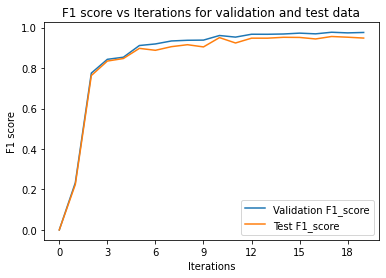

In [39]:
x=range(0,20)
 
ax = plt.figure().gca()
#...
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1scores,label="Validation F1_score")
ax.plot(test_f1scores,label="Test F1_score")
ax.set_xlabel('Iterations')
ax.set_ylabel('F1 score')
ax.legend()
ax.set_title('F1 score vs Iterations for validation and test data')
# naming the x axis 
#ax.xlabel('Iteration') 
# naming the y axis 
#ax.ylabel('F1 score') 
# giving a title to my graph 
#
# show a legend on the plot 
#ax.legend() 
  
# function to show the plot 


Lets define a method to load our saved model

In [40]:
def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
   
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

Lets test our model on  test data

In [41]:
ner = load_model("spacy_model")



test_sentences = [x[0] for x in TEST_DATA[0:4000]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")
   

ataxia 40 46 B_Disease
- 47 48 I_Disease
telangiectasia 49 63 I_Disease
T 83 84 B_Disease
- 85 86 I_Disease
cell 87 91 I_Disease
leukaemia 92 101 I_Disease


Ataxia 0 6 B_Disease
- 7 8 I_Disease
telangiectasia 9 23 I_Disease
A 26 27 B_Disease
- 28 29 I_Disease
T 30 31 I_Disease
multi 49 54 I_Disease
- 55 56 I_Disease
system 57 63 I_Disease
disorder 64 72 I_Disease


cancer 12 18 B_Disease
lymphoid 32 40 B_Disease
neoplasias 41 51 I_Disease
A 83 84 B_Disease
- 85 86 I_Disease
T 87 88 I_Disease


tumour 13 19 B_Disease
sporadic 43 51 B_Disease
T 52 53 I_Disease
- 54 55 I_Disease
cell 56 60 I_Disease
prolymphocytic 61 75 I_Disease
leukaemia 76 85 I_Disease
T 88 89 B_Disease
- 90 91 I_Disease
PLL 92 95 I_Disease
malignancy 114 124 I_Disease
T 155 156 B_Disease
- 157 158 I_Disease
cell 159 163 I_Disease
leukaemia 164 173 I_Disease
A 182 183 B_Disease
- 184 185 I_Disease
T 186 187 I_Disease


A 50 51 B_Disease
- 52 53 I_Disease
T 54 55 I_Disease
leukaemia 103 112 B_Disease


A 67 68 B_Disease
- 69 70 I_Disease
T 71 72 I_Disease


tumour 80 86 B_Disease
leukaemia 132 141 B_Disease


tumour 56 62 B_Disease
- 99 100 I_Disease
Hodgkins 101 109 I_Disease
lymphomas 110 119 I_Disease
B 122 123 B_Disease
- 124 125 I_Disease
NHL 126 129 I_Disease


tumours 151 158 B_Disease
sporadic 228 236 B_Disease
T 237 238 I_Disease
tumour 277 283 B_Disease


T 82 83 B_Disease


Myotonic 0 8 B_Disease
dystrophy 9 18 I_Disease


Myotonic 0 8 B_Disease
dystrophy 9 18 I_Disease
DM 21 23 B_Disease
muscular 47 55 B_Disease
disorder 56 64 I_Disease
DM 157 159 B_Disease


unilateral 62 72 B_Disease
retinoblastoma 73 87 I_Disease


unilateral 31 41 B_Disease
retinoblastoma 42 56 I_Disease
tumor 59 64 B_Disease


retinoblastoma 46 60 B_Disease


unilateral 103 113 B_Disease
retinoblastoma 114 128 I_Disease
tumor 178 183 B_Disease


tumors 16 22 B_Disease


tumors 25 31 B_Disease


tumors 45 51 B_Disease
LOH 57 60 B_Disease


tumors 20 26 B_Disease
LOH 35 38 B_Disease
tumors 94 100 B_Disease
LOH 109 112 B_Disease


tumors 50 56 B_Disease


multifocal 123 133 B_Disease
tumors 134 140 I_Disease
retinoblastoma 181 195 B_Disease


retinoblastoma 85 99 B_Disease


Hereditary 0 10 B_Disease
deficiency 11 21 I_Disease
of 22 24 I_Disease
the 25 28 I_Disease
fifth 29 34 I_Disease
component 35 44 I_Disease
of 45 47 I_Disease
complement 48 58 I_Disease


hereditary 40 50 B_Disease
deficiency 51 61 I_Disease
of 62 64 I_Disease
the 65 68 I_Disease
fifth 69 74 I_Disease
component 75 84 I_Disease
of 85 87 I_Disease
complement 88 98 I_Disease


systemic 50 58 B_Disease
lupus 59 64 I_Disease
erythematosus 65 78 I_Disease
hemolytic 107 116 I_Disease
complement 117 127 I_Disease


C5 159 161 B_Disease
deficiency 162 172 I_Disease


hemolytic 7 16 B_Disease
C5 57 59 B_Disease
- 60 61 I_Disease
deficient 62 71 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


membranous 52 62 B_Disease
glomerulonephritis 63 81 I_Disease
vasculitis 84 94 B_Disease
arthritis 101 110 B_Disease
bacterial 209 218 B_Disease
infections 219 229 I_Disease


neutrophilic 122 134 B_Disease
leukocytosis 135 147 I_Disease
pyogenic 155 163 B_Disease
infection 164 173 I_Disease


ankylosing 18 28 B_Disease
spondylitis 29 40 I_Disease


ankylosing 102 112 B_Disease
spondylitis 113 124 I_Disease
AS 127 129 B_Disease


AS 19 21 B_Disease
Rheumatic 75 84 B_Disease
Diseases 85 93 I_Disease


AS 138 140 B_Disease


AS 29 31 B_Disease


AS 75 77 B_Disease


breast 74 80 B_Disease
and 81 84 I_Disease
ovarian 85 92 I_Disease
cancer 93 99 I_Disease
tumor 152 157 B_Disease


tumor 109 114 B_Disease


hereditary 31 41 B_Disease
hemochromatosis 42 57 I_Disease
HH 60 62 B_Disease


HH 69 71 B_Disease


HH 75 77 B_Disease
cancer 178 184 B_Disease


Autosomal 0 9 B_Disease
dominant 10 18 I_Disease
neurohypophyseal 19 35 I_Disease
diabetes 36 44 I_Disease
insipidus 45 54 I_Disease


Autosomal 0 9 B_Disease
dominant 10 18 I_Disease
neurohypophyseal 19 35 I_Disease
diabetes 36 44 I_Disease
insipidus 45 54 I_Disease
inherited 71 80 B_Disease
disease 81 88 I_Disease
progressive 99 110 B_Disease
degeneration 111 123 I_Disease
of 124 126 I_Disease
the 127 130 I_Disease
magnocellular 131 144 I_Disease
arginine 225 233 I_Disease
vasopressin 234 245 I_Disease


diabetes 72 80 B_Disease
insipidus 81 90 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


PTEN 25 29 B_Disease
primary 41 48 B_Disease
prostate 49 57 I_Disease
cancer 58 64 I_Disease


Sporadic 0 8 B_Disease
prostate 9 17 I_Disease
carcinoma 18 27 I_Disease
male 47 51 B_Disease
cancer 52 58 I_Disease
cancer 167 173 B_Disease


sporadic 116 124 B_Disease
prostate 125 133 I_Disease
cancer 134 140 I_Disease


tumor 6 11 B_Disease
PTEN 30 34 B_Disease
prostate 151 159 B_Disease
cancer 160 166 I_Disease


prostate 15 23 B_Disease
tumors 24 30 I_Disease


tumors 65 71 B_Disease
PTEN 84 88 B_Disease
sporadic 142 150 B_Disease
prostate 151 159 I_Disease
cancer 160 166 I_Disease


Huntington 41 51 B_Disease
disease 52 59 I_Disease


Huntington 33 43 B_Disease
disease 44 51 I_Disease
HD 54 56 B_Disease
HD 173 175 B_Disease


HD 26 28 B_Disease


mucopolysaccharidosis 102 123 B_Disease
IVA 124 127 I_Disease


Mucopolysaccharidosis 0 21 B_Disease
IVA 22 25 I_Disease
MPS 28 31 B_Disease
IVA 32 35 I_Disease
autosomal 44 53 B_Disease
recessive 54 63 I_Disease
lysosomal 64 73 I_Disease
storage 74 81 I_Disease
disorder 82 90 I_Disease
genetic 103 110 B_Disease
defect 111 117 I_Disease


MPS 108 111 B_Disease
IVA 112 115 I_Disease


MPS 116 119 B_Disease
IVA 120 123 I_Disease


breast 55 61 B_Disease
/ 62 63 I_Disease
ovarian 64 71 I_Disease
cancer 72 78 I_Disease


breast 40 46 B_Disease
/ 47 48 I_Disease
ovarian 49 56 I_Disease
cancer 57 63 I_Disease


breast 47 53 B_Disease
cancer 54 60 I_Disease
breast 81 87 B_Disease
- 88 89 I_Disease
ovarian 90 97 I_Disease
cancer 98 104 I_Disease


breast 68 74 B_Disease
/ 75 76 I_Disease
ovarian 77 84 I_Disease
cancer 85 91 I_Disease


congenital 25 35 B_Disease
myotonic 36 44 I_Disease
dystrophy 45 54 I_Disease


congenital 48 58 B_Disease
myotonic 59 67 I_Disease
dystrophy 68 77 I_Disease
DM 80 82 B_Disease


mentally 31 39 B_Disease
retarded 40 48 I_Disease
muscular 73 81 B_Disease
weakness 82 90 I_Disease


DM 41 43 B_Disease


DM 40 42 B_Disease


congenital 49 59 B_Disease
DM 60 62 I_Disease


congenital 53 63 B_Disease
DM 64 66 I_Disease


DM 46 48 B_Disease
congenital 173 183 B_Disease
DM 184 186 I_Disease


congenital 187 197 B_Disease
DM 198 200 I_Disease


congenital 42 52 B_Disease
DM 53 55 I_Disease
DM 104 106 B_Disease


ectopic 38 45 B_Disease
intracranial 46 58 I_Disease
retinoblastoma 59 73 I_Disease


ectopic 55 62 B_Disease
intracranial 63 75 I_Disease
retinoblastoma 76 90 I_Disease
pineal 124 130 B_Disease
and 131 134 I_Disease
retinal 135 142 I_Disease
tumours 143 150 I_Disease


pineal 126 132 B_Disease
tumours 133 140 I_Disease


retinoblastoma 148 162 B_Disease


melanoma 104 112 B_Disease
deficiency 175 185 B_Disease
of 186 188 I_Disease
hex 189 192 I_Disease
A 193 194 I_Disease
Tay 249 252 B_Disease
- 253 254 I_Disease
Sachs 255 260 I_Disease
disease 261 268 I_Disease
TSD 271 274 B_Disease


TSD 109 112 B_Disease


TSD 93 96 B_Disease


TSD 133 136 B_Disease
deficiency 176 186 I_Disease
of 187 189 I_Disease
the 190 193 I_Disease
type 194 198 I_Disease


tumor 4 9 B_Disease


DPC4 25 29 B_Disease
tumor 30 35 I_Disease
pancreatic 139 149 B_Disease
cancers 150 157 I_Disease


Growth 0 6 B_Disease
retardation 7 18 I_Disease
the 22 25 I_Disease
Smad4 26 31 I_Disease
- 32 33 I_Disease
deficient 34 43 I_Disease


gastrulation 85 97 B_Disease
defect 98 104 I_Disease


gastrulation 118 130 B_Disease
defect 131 137 I_Disease


melanoma 52 60 B_Disease


Familial 11 19 B_Disease
Melanoma 20 28 I_Disease


melanoma 79 87 B_Disease


melanoma 53 61 B_Disease


familial 70 78 B_Disease
melanoma 79 87 I_Disease
melanoma 131 139 B_Disease


myotonic 77 85 B_Disease
dystrophy 86 95 I_Disease


myotonic 21 29 B_Disease
dystrophy 30 39 I_Disease
DM 42 44 B_Disease
DM 111 113 B_Disease


DM 37 39 B_Disease


DM 49 51 B_Disease
myotonic 140 148 B_Disease
dystrophy 149 158 I_Disease


Aspartylglucosaminuria 0 22 B_Disease


Aspartylglucosaminuria 0 22 B_Disease
AGU 25 28 B_Disease
disorder 41 49 B_Disease
of 50 52 I_Disease
glycoprotein 53 65 I_Disease
metabolism 66 76 I_Disease
deficiency 91 101 B_Disease
of 102 104 I_Disease
the 105 108 I_Disease
lysosomal 109 118 I_Disease
enzyme 119 125 I_Disease
aspartylglucosaminidase 126 149 I_Disease


AGU 0 3 B_Disease
autosomal 23 32 B_Disease


AGU 29 32 B_Disease


AGU 26 29 B_Disease


ataxia 42 48 B_Disease
- 49 50 I_Disease
telangiectasia 51 65 I_Disease


ataxia 3 9 B_Disease
- 10 11 I_Disease
telangiectasia 12 26 I_Disease
A 29 30 B_Disease
- 31 32 I_Disease
T 33 34 I_Disease
autosomal 96 105 B_Disease
recessive 106 115 I_Disease
syndrome 116 124 I_Disease
malignancy 243 253 B_Disease


A 62 63 B_Disease
- 64 65 I_Disease
T 66 67 I_Disease
cancer 79 85 B_Disease


A 85 86 B_Disease
- 87 88 I_Disease
T 89 90 I_Disease
A 114 115 B_Disease
- 116 117 I_Disease
T 118 119 I_Disease


A 5 6 B_Disease
- 7 8 I_Disease
T 9 10 I_Disease


A 107 108 B_Disease
- 109 110 I_Disease
T 111 112 I_Disease


familial 89 97 B_Disease
and 98 101 I_Disease
sporadic 102 110 I_Disease
cancers 111 118 I_Disease
tumor 191 196 B_Disease


Ataxia 0 6 B_Disease
- 7 8 I_Disease
telangiectasia 9 23 I_Disease


breast 97 103 B_Disease
cancer 104 110 I_Disease
ataxia 192 198 B_Disease
- 199 200 I_Disease
telangiectasia 201 215 I_Disease
A 218 219 B_Disease
- 220 221 I_Disease
T 222 223 I_Disease


A 45 46 B_Disease
- 47 48 I_Disease
T 49 50 I_Disease


von 4 7 B_Disease
Hippel 8 14 I_Disease
- 15 16 I_Disease
Lindau 17 23 I_Disease
tumor 24 29 I_Disease


von 24 27 B_Disease
Hippel 28 34 I_Disease
- 35 36 I_Disease
Lindau 37 43 I_Disease
VHL 46 49 B_Disease
tumor 52 57 B_Disease
VHL 120 123 B_Disease
cancer 124 130 I_Disease
syndrome 131 139 I_Disease
sporadic 163 171 B_Disease
renal 172 177 I_Disease
cell 178 182 I_Disease
carcinomas 183 193 I_Disease
RCC 196 199 B_Disease
brain 206 211 B_Disease
hemangioblastomas 212 229 I_Disease


VHL 0 3 B_Disease
VHL 107 110 B_Disease


cancer 34 40 B_Disease


VHL 58 61 B_Disease
VHL 91 94 B_Disease
RCC 106 109 B_Disease
cancer 110 116 I_Disease


VHL 5 8 B_Disease
VHL 24 27 B_Disease


VHL 108 111 B_Disease


VHL 40 43 B_Disease
tumor 144 149 B_Disease


VHL 55 58 B_Disease
VHL 73 76 B_Disease
tumor 90 95 B_Disease


Piebaldism 0 10 B_Disease
with 11 15 I_Disease
deafness 16 24 B_Disease
syndrome 62 70 I_Disease


piebaldism 51 61 B_Disease
congenital 75 85 B_Disease
sensorineural 86 99 I_Disease
deafness 100 108 I_Disease


auditory 7 15 B_Disease
anomalies 16 25 I_Disease
deafness 111 119 B_Disease
piebaldism 144 154 B_Disease


sensorineural 25 38 B_Disease
deafness 39 47 I_Disease
piebaldism 109 119 B_Disease
piebaldism 200 210 B_Disease
Waardenburg 236 247 B_Disease
syndrome 248 256 I_Disease


generalized 144 155 B_Disease
atrophic 156 164 I_Disease
benign 165 171 I_Disease
epidermolysis 172 185 I_Disease
bullosa 186 193 I_Disease


generalized 14 25 B_Disease
atrophic 26 34 I_Disease
benign 35 41 I_Disease
epidermolysis 42 55 I_Disease
bullosa 56 63 I_Disease


generalized 82 93 B_Disease
atrophic 94 102 I_Disease
benign 103 109 I_Disease
epidermolysis 110 123 I_Disease
bullosa 124 131 I_Disease


generalized 62 73 B_Disease
atrophic 74 82 I_Disease
benign 83 89 I_Disease
epidermolysis 90 103 I_Disease
bullosa 104 111 I_Disease


generalized 14 25 B_Disease
atrophic 26 34 I_Disease
benign 35 41 I_Disease
epidermolysis 42 55 I_Disease
bullosa 56 63 I_Disease
junctional 94 104 B_Disease
epidermolysis 105 118 I_Disease
bullosa 119 126 I_Disease
nail 159 163 B_Disease
dystrophy 164 173 I_Disease
patchy 176 182 B_Disease
alopecia 183 191 I_Disease
dental 198 204 B_Disease
abnormalities 205 218 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


generalized 51 62 B_Disease
atrophic 63 71 I_Disease
benign 72 78 I_Disease
epidermolysis 79 92 I_Disease
bullosa 93 100 I_Disease


anhaptoglobinemia 48 65 B_Disease


anhaptoglobinemia 89 106 B_Disease


anhaptoglobinemia 71 88 B_Disease


hypohaptoglobinemia 46 65 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


anhaptoglobinemia 53 70 B_Disease


hypohaptoglobinemia 27 46 B_Disease


ataxia 32 38 B_Disease
- 39 40 I_Disease
telangiectasia 41 55 I_Disease
leukemia 129 137 B_Disease
lymphoma 140 148 B_Disease
breast 155 161 B_Disease
cancer 162 168 I_Disease


ataxia 55 61 B_Disease
- 62 63 I_Disease
telangiectasia 64 78 I_Disease
A 81 82 B_Disease
- 83 84 I_Disease
T 85 86 I_Disease


cerebellar 178 188 B_Disease
degeneration 189 201 I_Disease


A 19 20 B_Disease
- 21 22 I_Disease
T 23 24 I_Disease
breast 119 125 B_Disease
cancer 126 132 I_Disease
A 243 244 B_Disease
- 245 246 I_Disease
T 247 248 I_Disease
cerebellar 285 295 B_Disease
degeneration 296 308 I_Disease


A 33 34 B_Disease
- 35 36 I_Disease
T 37 38 I_Disease
leukemia 81 89 B_Disease
lymphoma 92 100 B_Disease
preleukemic 103 114 B_Disease
T 115 116 I_Disease
Hodgkin 143 150 B_Disease
lymphoma 151 159 I_Disease


A 30 31 B_Disease
- 32 33 I_Disease
T 34 35 I_Disease


myotonic 35 43 B_Disease
dystrophy 44 53 I_Disease


myotonic 194 202 B_Disease
dystrophy 203 212 I_Disease


hemochromatosis 4 19 B_Disease


hereditary 68 78 B_Disease
hemochromatosis 79 94 I_Disease


hereditary 221 231 B_Disease
hemochromatosis 232 247 I_Disease


Angelman 107 115 B_Disease
syndrome 116 124 I_Disease
uniparental 191 202 B_Disease
disomy 203 209 I_Disease


Cowden 55 61 B_Disease
disease 62 69 I_Disease
Bannayan 74 82 B_Disease
- 83 84 I_Disease
Zonana 85 91 I_Disease
syndrome 92 100 I_Disease
hamartoma 107 116 B_Disease
syndromes 117 126 I_Disease
PTEN 141 145 B_Disease


tumour 4 10 B_Disease
PTEN 27 31 B_Disease


malignancy 153 163 B_Disease


PTEN 8 12 B_Disease
sporadic 54 62 B_Disease
breast 63 69 I_Disease
, 70 71 I_Disease
brain 72 77 I_Disease
, 78 79 I_Disease
prostate 80 88 B_Disease
and 89 92 I_Disease
kidney 93 99 I_Disease
cancer 100 106 I_Disease
tumours 141 148 B_Disease
endometrial 157 168 B_Disease
carcinomas 169 179 I_Disease
malignant 182 191 B_Disease
melanoma 192 200 I_Disease
thyroid 205 212 B_Disease
tumours 213 220 I_Disease


PTEN 14 18 B_Disease
hamartoma 69 78 B_Disease
syndromes 79 88 I_Disease
Cowden 89 95 I_Disease
disease 96 103 I_Disease
BZS 148 151 B_Disease
Ruvalcaba 157 166 B_Disease
- 167 168 I_Disease
Riley 169 174 I_Disease
- 175 176 I_Disease
Smith 177 182 I_Disease
syndrome 183 191 I_Disease


BZS 47 50 B_Disease
PTEN 86 90 B_Disease


PTEN 0 4 B_Disease


PTEN 15 19 B_Disease


PTEN 9 13 B_Disease
BZS 66 69 B_Disease


BZS 146 149 B_Disease


BZS 71 74 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


breast 68 74 B_Disease
disease 75 82 I_Disease


PTEN 92 96 B_Disease
malignant 110 119 B_Disease
breast 120 126 I_Disease
disease 127 134 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


complement 35 45 B_Disease
component 46 55 I_Disease
C6 56 58 I_Disease
deficiency 59 69 I_Disease


Complement 0 10 B_Disease
component 11 20 I_Disease
C6 21 23 I_Disease
deficiency 24 34 I_Disease
meningococcal 107 120 B_Disease
meningitis 121 131 I_Disease


meningitis 75 85 B_Disease
neisserial 95 105 B_Disease
infection 106 115 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


aniridia 44 52 B_Disease
Peters 95 101 B_Disease
anomaly 102 109 I_Disease
congenital 117 127 B_Disease
cataracts 128 137 I_Disease
autosomal 145 154 B_Disease
dominant 155 163 I_Disease
keratitis 164 173 I_Disease
foveal 194 200 B_Disease
hypoplasia 201 211 I_Disease


aniridia 60 68 B_Disease


breast 78 84 B_Disease
cancer 85 91 I_Disease


Breast 4 10 B_Disease
Cancer 11 17 I_Disease


inherited 39 48 B_Disease
breast 49 55 I_Disease
cancer 56 62 I_Disease
breast 160 166 B_Disease
cancer 167 173 I_Disease
Breast 193 199 B_Disease
Cancer 200 206 I_Disease


ovarian 59 66 B_Disease
or 67 69 I_Disease
other 70 75 I_Disease
cancers 76 83 I_Disease


breast 29 35 B_Disease
- 36 37 I_Disease
ovarian 38 45 I_Disease
cancer 46 52 I_Disease


breast 59 65 B_Disease
cancer 66 72 I_Disease


breast 119 125 B_Disease
cancer 126 132 I_Disease


breast 33 39 B_Disease
cancer 40 46 I_Disease


ovarian 18 25 B_Disease
cancer 26 32 I_Disease


breast 21 27 B_Disease
cancer 28 34 I_Disease


Eye 0 3 B_Disease
movement 4 12 I_Disease
abnormalities 13 26 I_Disease
autosomal 54 63 B_Disease
dominant 64 72 I_Disease
cerebellar 73 83 I_Disease
ataxia 84 90 I_Disease
type 91 95 I_Disease
I 96 97 I_Disease


horizontal 12 22 B_Disease
eye 23 26 I_Disease
autosomal 166 175 B_Disease
dominant 176 184 I_Disease
cerebellar 185 195 I_Disease
ataxias 196 203 I_Disease
type 204 208 I_Disease
I 209 210 I_Disease
spinocerebellar 211 226 I_Disease
ataxias 227 234 I_Disease
SCA3 281 285 B_Disease
/ 286 287 I_Disease
Machado 288 295 I_Disease
- 296 297 I_Disease
Joseph 298 304 I_Disease
disease 305 312 I_Disease
MJD 315 318 B_Disease


hypermetria 71 82 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


evoked 17 23 I_Disease
nystagmus 24 33 I_Disease
hypometria 67 77 B_Disease


nystagmus 92 101 I_Disease


idiopathic 42 52 B_Disease
ventricular 53 64 I_Disease
fibrillation 65 77 I_Disease


Ventricular 0 11 B_Disease
fibrillation 12 24 I_Disease
sudden 52 58 B_Disease


cardiac 69 76 B_Disease
non 80 83 I_Disease
- 84 85 I_Disease
cardiac 86 93 I_Disease
idiopathic 163 173 B_Disease
ventricular 174 185 I_Disease
fibrillation 186 198 I_Disease
IVF 201 204 B_Disease


IVF 20 23 B_Disease


sudden 70 76 B_Disease
death 77 82 I_Disease
IVF 124 127 B_Disease


IVF 8 11 B_Disease
cardiac 19 26 B_Disease
rhythm 27 33 I_Disease


IVF 138 141 B_Disease


IVF 104 107 B_Disease


mucopolysaccharidosis 27 48 B_Disease
IVA 49 52 I_Disease


Mucopolysaccharidosis 0 21 B_Disease
IVA 22 25 I_Disease
MPS 28 31 B_Disease
IVA 32 35 I_Disease
autosomal 44 53 B_Disease
recessive 54 63 I_Disease
lysosomal 64 73 I_Disease
storage 74 81 I_Disease
disorder 82 90 I_Disease
genetic 103 110 B_Disease
defect 111 117 I_Disease


MPS 135 138 B_Disease
IVA 139 142 I_Disease


MPS 58 61 B_Disease
IVA 62 65 I_Disease


MPS 75 78 B_Disease
IVA 79 82 I_Disease


mesangial 83 92 B_Disease
sclerosis 93 102 I_Disease


renal 101 106 B_Disease
and 107 110 I_Disease
gonadal 111 118 I_Disease
Denys 165 170 B_Disease
- 171 172 I_Disease
Drash 173 178 I_Disease
syndrome 179 187 I_Disease
DDS 190 193 B_Disease
mesangial 209 218 B_Disease
sclerosis 219 228 I_Disease
DMS 231 234 B_Disease
pseudohermaphroditism 253 274 B_Disease
Wilms 284 289 B_Disease
tumor 290 295 I_Disease
WT 298 300 B_Disease


DDS 18 21 B_Disease


DMS 55 58 B_Disease
DDS 78 81 B_Disease
urogenital 95 105 B_Disease
abnormalities 106 119 I_Disease
WT 129 131 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


DDS 73 76 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


DMS 79 82 B_Disease
DMS 111 114 B_Disease


familial 69 77 B_Disease
breast 78 84 I_Disease
and 85 88 I_Disease
ovarian 89 96 I_Disease
cancer 97 103 I_Disease


breast 142 148 B_Disease
/ 149 150 I_Disease
ovarian 151 158 I_Disease
cancer 159 165 I_Disease


hemochromatosis 25 40 B_Disease


overload 62 70 I_Disease
disease 71 78 I_Disease
hereditary 79 89 I_Disease
hemochromatosis 90 105 I_Disease


hemochromatosis 54 69 B_Disease


Wilson 111 117 B_Disease
disease 118 125 I_Disease


Wilson 167 173 B_Disease
disease 174 181 I_Disease


Wilson 166 172 B_Disease
disease 173 180 I_Disease


myotonic 63 71 B_Disease
dystrophy 72 81 I_Disease


Myotonic 0 8 B_Disease
dystrophy 9 18 I_Disease
DM 21 23 B_Disease
DM 91 93 B_Disease


DM 13 15 B_Disease


DM 34 36 B_Disease


DM 100 102 B_Disease
pathogenesis 103 115 I_Disease


familial 142 150 B_Disease
neurohypophyseal 151 167 I_Disease
diabetes 168 176 I_Disease
insipidus 177 186 I_Disease


Familial 0 8 B_Disease
neurohypophyseal 9 25 I_Disease
diabetes 26 34 I_Disease
insipidus 35 44 I_Disease
FNDI 47 51 B_Disease
autosomal 60 69 B_Disease
dominant 70 78 I_Disease
disease 79 86 I_Disease
deficiency 97 107 B_Disease
in 108 110 I_Disease
the 111 114 I_Disease
antidiuretic 115 127 I_Disease
hormone 128 135 I_Disease
arginine 136 144 I_Disease
vasopressin 145 156 I_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Saethre 25 32 B_Disease
- 33 34 I_Disease
Chotzen 35 42 I_Disease
syndrome 43 51 I_Disease


Saethre 49 56 B_Disease
- 57 58 I_Disease
Chotzen 59 66 I_Disease
syndrome 67 75 I_Disease
autosomal 87 96 B_Disease
dominant 97 105 I_Disease
condition 106 115 I_Disease
of 116 118 I_Disease
craniosynostosis 119 135 B_Disease
and 136 139 I_Disease
limb 140 144 I_Disease
anomalies 145 154 I_Disease
FGFR3 208 213 B_Disease


Saethre 72 79 B_Disease
- 80 81 I_Disease
Chotzen 82 89 I_Disease
syndrome 90 98 I_Disease


coronal 110 117 B_Disease
synostosis 118 128 I_Disease
brachycephaly 131 144 B_Disease
frontal 151 158 B_Disease
hairline 159 167 I_Disease
facial 170 176 B_Disease
asymmetry 177 186 I_Disease
ptosis 189 195 B_Disease
hypertelorism 198 211 B_Disease
clinodactyly 237 249 B_Disease


Saethre 140 147 B_Disease
- 148 149 I_Disease
Chotzen 150 157 I_Disease
Pfeiffer 174 182 B_Disease
syndromes 183 192 I_Disease
craniofacial 314 326 B_Disease
and 327 330 I_Disease
limb 331 335 I_Disease


Angelman 30 38 B_Disease
syndrome 39 47 I_Disease


Angelman 0 8 B_Disease
syndrome 9 17 I_Disease
AS 20 22 B_Disease
uniparental 104 115 B_Disease
disomy 116 122 I_Disease
UPD 125 128 B_Disease


AS 81 83 B_Disease


AS 112 114 B_Disease
AS 157 159 B_Disease
AS 200 202 B_Disease


hemochromatosis 4 19 B_Disease


Hemochromatosis 0 15 B_Disease
inherited 22 31 B_Disease
disorder 32 40 I_Disease
of 41 43 I_Disease
iron 44 48 I_Disease
metabolism 49 59 I_Disease
premature 118 127 B_Disease
death 128 133 I_Disease


hemochromatosis 4 19 B_Disease


hemochromatosis 9 24 B_Disease


attenuated 37 47 B_Disease
adenomatous 48 59 I_Disease
polyposis 60 69 I_Disease
coli 70 74 I_Disease


tumor 29 34 B_Disease
APC 46 49 B_Disease
attenuated 68 78 B_Disease
adenomatous 79 90 I_Disease
polyposis 91 100 I_Disease
coli 101 105 I_Disease
AAPC 108 112 B_Disease
familial 130 138 B_Disease
adenomatous 139 150 I_Disease
polyposis 151 160 I_Disease
FAP 163 166 B_Disease


AAPC 0 4 B_Disease
colonic 46 53 B_Disease
adenomas 54 62 I_Disease
colorectal 84 94 B_Disease
cancer 95 101 I_Disease


AAPC 73 77 B_Disease


PTT 31 34 B_Disease
APC 77 80 B_Disease
AAPC 131 135 B_Disease


APC 23 26 B_Disease


APC 57 60 B_Disease


colorectal 29 39 B_Disease
adenomas 40 48 I_Disease


adenomas 85 93 B_Disease


AAPC 7 11 B_Disease
colorectal 55 65 I_Disease
adenomas 66 74 I_Disease
rectal 79 85 B_Disease
polyp 86 91 I_Disease


desmoid 3 10 B_Disease
tumors 11 17 I_Disease


AAPC 27 31 B_Disease
APC 63 66 B_Disease


FAP 93 96 B_Disease


Wilms 0 5 B_Disease
' 6 7 I_Disease
tumor 8 13 I_Disease


Wilms 50 55 B_Disease
tumor 56 61 I_Disease
gonadogenesis 106 119 I_Disease


Denys 85 90 B_Disease
- 91 92 I_Disease
Drash 93 98 I_Disease
syndrome 99 107 I_Disease


Prader 18 24 B_Disease
- 25 26 I_Disease
Willi 27 32 I_Disease
syndrome 33 41 I_Disease


Prader 86 92 B_Disease
- 93 94 I_Disease
Willi 95 100 I_Disease
syndrome 101 109 I_Disease
PWS 112 115 B_Disease


PWS 61 64 B_Disease


PWS 140 143 B_Disease


PWS 66 69 B_Disease
PWS 209 212 B_Disease


ataxia 47 53 B_Disease
- 54 55 I_Disease
telangiectasia 56 70 I_Disease


recessive 69 78 B_Disease
disease 79 86 I_Disease
ataxia 87 93 I_Disease
- 94 95 I_Disease
telangiectasia 96 110 I_Disease
A 113 114 B_Disease
- 115 116 I_Disease
T 117 118 I_Disease


A 76 77 B_Disease
- 78 79 I_Disease
T 80 81 I_Disease
A 235 236 B_Disease
- 237 238 I_Disease
T 239 240 I_Disease


gangliosidosis 146 160 I_Disease


Tay 138 141 B_Disease
- 142 143 I_Disease
Sachs 144 149 I_Disease
disease 150 157 I_Disease
TSD 160 163 B_Disease
gangliosidosis 205 219 I_Disease


gangliosidosis 178 192 B_Disease


TSD 371 374 B_Disease


A 65 66 B_Disease
enzyme 67 73 I_Disease
deficiency 74 84 I_Disease


A 206 207 B_Disease
deficiency 208 218 I_Disease


Pendred 35 42 B_Disease
syndrome 43 51 I_Disease


Pendred 0 7 B_Disease
syndrome 8 16 I_Disease
autosomal 23 32 B_Disease
recessive 33 42 I_Disease
disorder 43 51 I_Disease
childhood 75 84 B_Disease
deafness 85 93 I_Disease
goiter 98 104 B_Disease


PDS 38 41 B_Disease


Pendred 0 7 B_Disease


PDS 35 38 B_Disease
Pendred 92 99 B_Disease
syndrome 100 108 I_Disease


DMD 59 62 B_Disease
X 79 80 B_Disease
- 81 82 I_Disease
linked 83 89 I_Disease
dilated 90 97 I_Disease
cardiomyopathy 98 112 I_Disease


X 0 1 B_Disease
- 2 3 I_Disease
linked 4 10 I_Disease
dilated 11 18 I_Disease
cardiomyopathy 19 33 I_Disease
XLDCM 36 41 B_Disease
dystrophinopathy 71 87 B_Disease
myocardial 127 137 B_Disease
myopathy 195 203 I_Disease


Duchenne 35 43 B_Disease
muscular 44 52 I_Disease
dystrophy 53 62 I_Disease
DMD 70 73 B_Disease
XLDCM 114 119 B_Disease
DMD 188 191 B_Disease
XLDCM 201 206 B_Disease


DMD 91 94 B_Disease
XLDCM 104 109 B_Disease


DMD 54 57 B_Disease


obesity 21 28 B_Disease
adrenal 31 38 B_Disease
insufficiency 39 52 I_Disease


ACTH 30 34 B_Disease
deficiency 35 45 I_Disease
POMC 96 100 B_Disease
defect 101 107 I_Disease


obesity 211 218 B_Disease
obesity 331 338 B_Disease


obesity 173 180 B_Disease
ACTH 214 218 B_Disease
deficiency 219 229 I_Disease


genetic 49 56 B_Disease
defect 57 63 I_Disease
monogenic 102 111 B_Disease
endocrine 112 121 I_Disease
disorder 122 130 I_Disease
obesity 158 165 B_Disease
adrenal 168 175 B_Disease
insufficiency 176 189 I_Disease


phenylalanine 32 45 B_Disease
hydroxylase 46 57 I_Disease
deficiency 58 68 I_Disease


Phenylketonuria 0 15 B_Disease
PKU 18 21 B_Disease
hyperphenylalaninemia 33 54 B_Disease
MHP 57 60 B_Disease
allelic 67 74 B_Disease
disorders 75 84 I_Disease


PAH 81 84 B_Disease
deficiency 85 95 I_Disease


PAH 120 123 B_Disease
deficiency 124 134 I_Disease


hyperphenylalaninemia 185 206 B_Disease


myotonic 65 73 B_Disease
dystrophy 74 83 I_Disease


DM 67 69 B_Disease
myotonic 126 134 B_Disease
dystrophy 135 144 I_Disease
DM 147 149 B_Disease


DM 60 62 B_Disease
genetic 79 86 B_Disease
diseases 87 95 I_Disease


DM 184 186 B_Disease


DM 38 40 B_Disease


retinoblastoma 45 59 B_Disease
tumor 105 110 B_Disease


retinoblastoma 160 174 B_Disease


unilateral 46 56 B_Disease
tumors 57 63 I_Disease


tumors 106 112 B_Disease


Maternal 0 8 B_Disease
disomy 9 15 I_Disease
Prader 20 26 B_Disease
- 27 28 I_Disease
Willi 29 34 I_Disease
syndrome 35 43 I_Disease


Maternal 0 8 B_Disease
uniparental 9 20 I_Disease
disomy 21 27 I_Disease
UPD 30 33 B_Disease
Prader 103 109 B_Disease
- 110 111 I_Disease
Willi 112 117 I_Disease
syndrome 118 126 I_Disease
PWS 129 132 B_Disease


maternal 32 40 B_Disease
disomy 41 47 I_Disease
PWS 54 57 B_Disease


PWS 60 63 B_Disease


PWS 65 68 B_Disease
PWS 162 165 B_Disease


Maternal 0 8 B_Disease
disomy 9 15 I_Disease


Uniparental 0 11 B_Disease
disomy 12 18 I_Disease
PWS 184 187 B_Disease


UPD 101 104 B_Disease
PWS 112 115 B_Disease


Schwartz 0 8 B_Disease
- 9 10 I_Disease
Jampel 11 17 I_Disease
syndrome 18 26 I_Disease
type 27 31 I_Disease
2 32 33 I_Disease
and 34 37 I_Disease
Stuve 38 43 I_Disease
- 44 45 I_Disease
Wiedemann 46 55 I_Disease
syndrome 56 64 I_Disease


Schwartz 97 105 B_Disease
- 106 107 I_Disease
Jampel 108 114 I_Disease
syndrome 115 123 I_Disease
SJS 126 129 B_Disease
myotonia 135 143 B_Disease
skeletal 148 156 I_Disease
dysplasia 157 166 I_Disease
SJS 185 188 B_Disease
type 189 193 I_Disease
2 194 195 I_Disease


disorder 5 13 B_Disease
Stuve 61 66 B_Disease
- 67 68 I_Disease
Wiedemann 69 78 I_Disease
syndrome 79 87 I_Disease
SWS 90 93 B_Disease
campomelia 114 124 B_Disease
skeletal 139 147 B_Disease
dysplasia 148 157 I_Disease
contractures 160 172 B_Disease


SJS 166 169 B_Disease
type 170 174 I_Disease
SWS 210 213 B_Disease


neonatal 35 43 B_Disease
SJS 44 47 I_Disease
SWS 51 54 B_Disease
neuromuscular 110 123 B_Disease
disorder 124 132 I_Disease
congenital 140 150 B_Disease
joint 151 156 I_Disease
contractures 157 169 I_Disease
hyperthermia 223 235 B_Disease
skeletal 311 319 I_Disease
dysplasia 320 329 I_Disease


bone 78 82 B_Disease
dysplasia 83 92 I_Disease
SJS 124 127 B_Disease
type 128 132 I_Disease
SWS 146 149 B_Disease


SWS 20 23 B_Disease
SJS 28 31 B_Disease
type 32 36 I_Disease
disorder 52 60 I_Disease


von 24 27 B_Disease
Willebrand 28 38 I_Disease
disease 39 46 I_Disease
defects 49 56 B_Disease
hemostasis 60 70 B_Disease
thrombosis 75 85 B_Disease


von 0 3 B_Disease
Willebrand 4 14 I_Disease
deficiency 30 40 I_Disease
von 55 58 B_Disease
Willebrand 59 69 I_Disease
disease 70 77 I_Disease


- 4 5 B_Disease
deficient 6 15 I_Disease


von 37 40 B_Disease
Willebrand 41 51 I_Disease
antigen 52 59 I_Disease
II 60 62 I_Disease


thrombosis 10 20 B_Disease
vascular 76 84 B_Disease
injury 85 91 I_Disease


von 60 63 B_Disease
Willebrand 64 74 I_Disease
disease 75 82 I_Disease


hereditary 36 46 B_Disease
ovarian 47 54 I_Disease
cancer 55 61 I_Disease


Hereditary 0 10 B_Disease
Ovarian 11 18 I_Disease
Cancer 19 25 I_Disease


ovarian 99 106 B_Disease
cancer 107 113 I_Disease


ovarian 36 43 B_Disease
cancer 44 50 I_Disease
hereditary 118 128 B_Disease
forms 129 134 I_Disease
of 135 137 I_Disease
ovarian 138 145 I_Disease
cancer 146 152 I_Disease


hereditary 35 45 B_Disease
ovarian 46 53 I_Disease
cancer 54 60 I_Disease


ovarian 36 43 B_Disease
cancer 44 50 I_Disease


ovarian 43 50 B_Disease
cancer 51 57 I_Disease


ovarian 60 67 B_Disease
cancer 68 74 I_Disease


adrenoleukodystrophy 23 43 B_Disease


adrenoleukodystrophy 33 53 B_Disease
ALD 56 59 B_Disease
ALD 116 119 B_Disease


cerebral 91 99 B_Disease
and 100 103 I_Disease
cerebello 104 113 I_Disease
- 114 115 I_Disease
brain 116 121 I_Disease
ALD 210 213 B_Disease


Alzheimers 99 109 B_Disease
disease 110 117 I_Disease
AD 120 122 B_Disease


abnormalities 50 63 B_Disease
cerebral 136 144 B_Disease
white 145 150 I_Disease
oxygen 215 221 B_Disease
metabolism 222 232 I_Disease
PET 293 296 B_Disease


ALD 176 179 B_Disease


ALD 84 87 B_Disease


PET 84 87 B_Disease
insidious 102 111 B_Disease
lesion 112 118 I_Disease
neuronal 244 252 B_Disease
degeneration 253 265 I_Disease
ALD 269 272 B_Disease


complement 37 47 B_Disease
C9 48 50 I_Disease
complement 87 97 B_Disease
C9 98 100 I_Disease
deficiency 101 111 I_Disease


Deficiency 0 10 B_Disease
of 11 13 I_Disease
the 14 17 I_Disease
ninth 18 23 I_Disease
component 24 33 I_Disease
of 34 36 I_Disease
human 37 42 I_Disease
complement 43 53 I_Disease
complement 80 90 B_Disease
deficiency 91 101 I_Disease


C9 34 36 B_Disease
deficiency 37 47 I_Disease
C9 65 67 B_Disease
- 68 69 I_Disease
deficient 70 79 I_Disease
meningococcal 111 124 B_Disease
meningitis 125 135 I_Disease


C9 132 134 B_Disease
- 135 136 I_Disease
deficient 137 146 I_Disease


C9 81 83 B_Disease
deficiency 84 94 I_Disease


breast 4 10 B_Disease
and 11 14 I_Disease
ovarian 15 22 I_Disease
cancer 23 29 I_Disease


hypersensitive 177 191 B_Disease


aniridia 87 95 B_Disease
Peters 98 104 B_Disease
anomaly 105 112 I_Disease
autosomal 115 124 B_Disease
dominant 125 133 I_Disease
keratitis 134 143 I_Disease
familial 150 158 B_Disease
foveal 159 165 I_Disease
dysplasia 166 175 I_Disease


aniridia 80 88 B_Disease
genetic 106 113 B_Disease
haploinsufficiency 114 132 I_Disease


Aniridia 114 122 B_Disease


aniridia 76 84 B_Disease


hypertrophic 19 31 B_Disease
cardiomyopathy 32 46 I_Disease
coenzyme 116 124 I_Disease
A 125 126 I_Disease
dehydrogenase 127 140 I_Disease
deficiency 141 151 I_Disease


coenzyme 27 35 I_Disease
A 36 37 I_Disease
dehydrogenase 38 51 I_Disease
( 52 53 I_Disease
VLCAD 54 59 B_Disease
) 60 61 I_Disease
deficiency 62 72 I_Disease
disorder 78 86 B_Disease
of 87 89 I_Disease
fatty 90 95 I_Disease


VLCAD 54 59 B_Disease
deficiency 60 70 I_Disease
hypertrophic 121 133 B_Disease
cardiomyopathy 134 148 I_Disease
hepatomegaly 151 163 B_Disease
encephalopathy 166 180 B_Disease
hypotonia 187 196 B_Disease


VLCAD 30 35 B_Disease
deficiency 36 46 I_Disease


VLCAD 24 29 B_Disease
deficiency 30 40 I_Disease
cardiomyopathy 112 126 B_Disease


diabetes 117 125 B_Disease
mellitus 126 134 I_Disease


diabetes 94 102 B_Disease


APC 4 7 B_Disease
colorectal 55 65 B_Disease
tumors 66 72 I_Disease


Classical 0 9 B_Disease
familial 10 18 I_Disease
adenomatous 19 30 I_Disease
polyposis 31 40 I_Disease
FAP 43 46 B_Disease
autosomal 72 81 B_Disease
dominant 82 90 I_Disease
disease 91 98 I_Disease
colorectal 144 154 B_Disease
adenomas 155 163 I_Disease
carcinoma 168 177 B_Disease
APC 228 231 B_Disease


FAP 13 16 B_Disease
attenuated 20 30 B_Disease
adenomatous 31 42 I_Disease
polyposis 43 52 I_Disease
coli 53 57 I_Disease
APC 131 134 B_Disease


Attenuated 0 10 B_Disease
adenomatous 11 22 I_Disease
polyposis 23 32 I_Disease
coli 33 37 I_Disease
colorectal 65 75 B_Disease
adenomas 76 84 I_Disease
FAP 156 159 B_Disease


adenomas 40 48 B_Disease
APC 73 76 B_Disease


APC 43 46 B_Disease
colorectal 106 116 B_Disease
tumors 117 123 I_Disease
adenomas 145 153 B_Disease


colorectal 52 62 B_Disease
adenomas 63 71 I_Disease
carcinoma 81 90 B_Disease
APC 143 146 B_Disease


APC 59 62 B_Disease
metaplastic 156 167 B_Disease
polyps 168 174 I_Disease
of 175 177 I_Disease
the 178 181 I_Disease
colorectum 182 192 I_Disease


APC 74 77 B_Disease
colorectal 130 140 B_Disease
adenomas 141 149 I_Disease
carcinoma 154 163 B_Disease
FAP 212 215 B_Disease
colorectal 251 261 B_Disease
cancer 262 268 I_Disease


congenital 31 41 B_Disease
chloride 42 50 I_Disease
diarrhea 51 59 I_Disease
CLD 62 65 B_Disease


Congenital 0 10 B_Disease
chloride 11 19 I_Disease
diarrhea 20 28 I_Disease
CLD 31 34 B_Disease


CLD 62 65 B_Disease


CLD 140 143 B_Disease


BAC 24 27 B_Disease
CLD 114 117 B_Disease
Pendred 187 194 B_Disease
syndrome 195 203 I_Disease
PDS 211 214 B_Disease


cancer 25 31 B_Disease


APC 13 16 B_Disease
familial 49 57 B_Disease
adenomatous 58 69 I_Disease
polyposis 70 79 I_Disease
FAP 82 85 B_Disease
autosomal 109 118 B_Disease
dominant 119 127 I_Disease
disorder 128 136 I_Disease
intestinal 163 173 B_Disease
polyps 174 180 I_Disease
colorectal 238 248 B_Disease
cancer 249 255 I_Disease


APC 0 3 B_Disease
tumour 9 15 B_Disease
tumours 63 70 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cancer 34 40 B_Disease


colorectal 19 29 B_Disease
breast 32 38 B_Disease
and 39 42 I_Disease
other 43 48 I_Disease
cancers 49 56 I_Disease


Friedreich 24 34 B_Disease
ataxia 35 41 I_Disease
FRDA 113 117 B_Disease


Friedreich 0 10 B_Disease
ataxia 11 17 I_Disease
FRDA 101 105 B_Disease


metachromatic 53 66 B_Disease
leukodystrophy 67 81 I_Disease


Deficiency 0 10 B_Disease
of 11 13 I_Disease
arylsulfatase 14 27 I_Disease
metachromatic 62 75 B_Disease
leukodystrophy 76 90 I_Disease
MLD 93 96 B_Disease


MLD 48 51 B_Disease


MLD 68 71 B_Disease


MLD 131 134 B_Disease


renal 58 63 B_Disease
cell 64 68 I_Disease
carcinoma 69 78 I_Disease
von 105 108 I_Disease
Hippel 109 115 I_Disease
- 116 117 I_Disease
Lindau 118 124 I_Disease


von 30 33 B_Disease
Hippel 34 40 I_Disease
- 41 42 I_Disease
Lindau 43 49 I_Disease
VHL 52 55 B_Disease
renal 94 99 B_Disease
cell 100 104 I_Disease
carcinoma 105 114 I_Disease
VHL 162 165 B_Disease


VHL 25 28 B_Disease
renal 100 105 B_Disease
cell 106 110 I_Disease
carcinoma 111 120 I_Disease


VHL 29 32 B_Disease


cancers 62 69 B_Disease


CA 66 68 B_Disease
XII 69 72 I_Disease
cancer 171 177 B_Disease


diabetes 68 76 B_Disease
mellitus 77 85 I_Disease
optic 90 95 B_Disease
atrophy 96 103 I_Disease
Wolfram 106 113 B_Disease
syndrome 114 122 I_Disease


Wolfram 0 7 B_Disease
syndrome 8 16 I_Disease
WFS 19 22 B_Disease
autosomal 45 54 B_Disease
recessive 55 64 I_Disease
neurodegenerative 65 82 I_Disease
disorder 83 91 I_Disease
- 138 139 I_Disease
dependent 140 149 I_Disease
diabetes 150 158 I_Disease
mellitus 159 167 I_Disease
progressive 172 183 B_Disease
optic 184 189 I_Disease
atrophy 190 197 I_Disease


WFS 79 82 B_Disease
BAC 107 110 B_Disease


WFS 123 126 B_Disease


tumor 63 68 B_Disease


breast 65 71 B_Disease
and 72 75 I_Disease
/ 76 77 I_Disease
or 78 80 I_Disease
ovarian 81 88 I_Disease
cancer 89 95 I_Disease


Dysfunction 0 11 B_Disease
hereditary 84 94 B_Disease
breast 95 101 I_Disease
and 102 105 I_Disease
/ 106 107 I_Disease
or 108 110 I_Disease
ovarian 111 118 I_Disease
cancer 119 125 I_Disease


cerebrotendinous 149 165 B_Disease
xanthomatosis 166 179 I_Disease
CTX 182 185 B_Disease


deficiency 120 130 B_Disease


ataxia 36 42 B_Disease
- 43 44 I_Disease
telangiectasia 45 59 I_Disease


autosomal 59 68 B_Disease
recessive 69 78 I_Disease
disorder 79 87 I_Disease
ataxia 88 94 I_Disease
- 95 96 I_Disease
telangiectasia 97 111 I_Disease
A 114 115 B_Disease
- 116 117 I_Disease
T 118 119 I_Disease


A 76 77 B_Disease
- 78 79 I_Disease
T 80 81 I_Disease


A 75 76 B_Disease
- 77 78 I_Disease
T 79 80 I_Disease
A 136 137 B_Disease
- 138 139 I_Disease
T 140 141 I_Disease


A 34 35 B_Disease
- 36 37 I_Disease
T 38 39 I_Disease


autosomal 89 98 B_Disease
recessive 99 108 I_Disease
Alport 109 115 I_Disease
syndrome 116 124 I_Disease


Autosomal 0 9 B_Disease
recessive 10 19 I_Disease
Alport 20 26 I_Disease
syndrome 27 35 I_Disease
hematuric 53 62 B_Disease
glomerulonephritis 63 81 I_Disease
glomerular 99 109 B_Disease
basement 110 118 I_Disease
membrane 119 127 I_Disease
abnormalities 128 141 I_Disease


autosomal 196 205 B_Disease
recessive 206 215 I_Disease
Alport 216 222 I_Disease
syndrome 223 231 I_Disease


breast 53 59 B_Disease
and 60 63 I_Disease
ovarian 64 71 I_Disease
cancer 72 78 I_Disease


breast 49 55 B_Disease
cancer 56 62 I_Disease
breast 125 131 B_Disease
cancer 132 138 I_Disease
breast 143 149 B_Disease
/ 150 151 I_Disease
ovarian 152 159 I_Disease
cancer 160 166 I_Disease


cancer 84 90 B_Disease


ovarian 35 42 B_Disease
cancer 43 49 I_Disease


breast 48 54 B_Disease
cancer 55 61 I_Disease


breast 34 40 B_Disease
cancer 41 47 I_Disease


breast 108 114 B_Disease
cancer 115 121 I_Disease
breast 126 132 B_Disease
/ 133 134 I_Disease
ovarian 135 142 I_Disease
cancer 143 149 I_Disease


cognitive 56 65 B_Disease
impairment 66 76 I_Disease
Duchenne 80 88 B_Disease
muscular 89 97 I_Disease
dystrophy 98 107 I_Disease


Duchenne 96 104 B_Disease
muscular 105 113 I_Disease
dystrophy 114 123 I_Disease
DMD 126 129 B_Disease
DMD 219 222 B_Disease


DMD 141 144 B_Disease


cognitive 190 199 B_Disease
impairment 200 210 I_Disease


cerebral 105 113 B_Disease
dysfunction 114 125 I_Disease


DMD 109 112 B_Disease
DMD 204 207 B_Disease


APC 7 10 B_Disease
hereditary 61 71 B_Disease
non 72 75 I_Disease
- 76 77 I_Disease
polyposis 78 87 I_Disease
colorectal 88 98 I_Disease
cancer 99 105 I_Disease


hereditary 30 40 B_Disease
non 41 44 I_Disease
- 45 46 I_Disease
polyposis 47 56 I_Disease
colorectal 57 67 I_Disease
cancer 68 74 I_Disease
HNPCC 77 82 B_Disease


APC 27 30 B_Disease
colorectal 83 93 B_Disease
cancer 94 100 I_Disease


cancer 130 136 B_Disease


hereditary 65 75 B_Disease
coproporphyria 76 90 I_Disease


Hereditary 0 10 B_Disease
coproporphyria 11 25 I_Disease
HCP 28 31 B_Disease
autosomal 40 49 B_Disease
dominant 50 58 I_Disease
disease 59 66 I_Disease
deficiency 86 96 B_Disease
of 97 99 I_Disease
coproporphyrinogen 100 118 I_Disease
oxidase 119 126 I_Disease


HCP 52 55 B_Disease


complement 6 16 B_Disease
factor 17 23 I_Disease
H 24 25 I_Disease
deficiency 26 36 I_Disease
hemolytic 53 62 B_Disease
uremic 63 69 I_Disease
syndrome 70 78 I_Disease


deficiency 35 45 B_Disease
FH 100 102 B_Disease
acute 126 131 B_Disease
renal 132 137 I_Disease
disease 138 145 I_Disease


idiopathic 60 70 B_Disease
hemolytic 71 80 I_Disease
uremic 81 87 I_Disease
syndrome 88 96 I_Disease


Factor 0 6 B_Disease
H 7 8 I_Disease
deficiency 9 19 I_Disease
complement 32 42 B_Disease
deficiency 43 53 I_Disease


FH 38 40 B_Disease
FH 50 52 B_Disease
idiopathic 86 96 B_Disease
HUS 97 100 I_Disease


myotonic 57 65 B_Disease
dystrophy 66 75 I_Disease


myotonic 4 12 B_Disease
dystrophy 13 22 I_Disease
DM 25 27 B_Disease
DM 175 177 B_Disease


DM 48 50 B_Disease


DM 52 54 B_Disease


DM 40 42 B_Disease


DM 165 167 B_Disease


DM 97 99 B_Disease
Friedreichs 104 115 B_Disease
ataxia 116 122 I_Disease


C6 23 25 B_Disease
deficiency 26 36 I_Disease


Deficiency 0 10 B_Disease
of 11 13 I_Disease
the 14 17 I_Disease
sixth 18 23 I_Disease
component 24 33 I_Disease
of 34 36 I_Disease
human 37 42 I_Disease
complement 43 53 I_Disease
C6 56 58 I_Disease


Meningococcal 0 13 B_Disease
disease 14 21 I_Disease
C6 79 81 B_Disease
deficiency 82 92 I_Disease
recurrent 135 144 B_Disease
disease 145 152 I_Disease


C6 54 56 B_Disease
- 57 58 I_Disease
deficient 59 68 I_Disease


Complement 0 10 B_Disease
C7 11 13 I_Disease
deficiency 14 24 I_Disease


C7 33 35 B_Disease
deficiency 36 46 I_Disease


C7 51 53 B_Disease
defects 54 61 I_Disease


mental 54 60 B_Disease
health 61 67 I_Disease
wellness 68 76 I_Disease
bipolar 107 114 B_Disease
affective 115 124 I_Disease
disorder 125 133 I_Disease


Bipolar 0 7 B_Disease
affective 8 17 I_Disease
disorder 18 26 I_Disease
BPAD 29 33 B_Disease
manic 36 41 B_Disease
- 42 43 I_Disease
depressive 44 54 I_Disease
illness 55 62 I_Disease


BPAD 94 98 B_Disease


BPAD 131 135 B_Disease


BPAD 101 105 B_Disease
genetic 145 152 B_Disease
disorders 153 162 I_Disease
mental 173 179 B_Disease
health 180 186 I_Disease
wellness 187 195 I_Disease
psychiatric 213 224 B_Disease
disorder 225 233 I_Disease
BPAD 388 392 B_Disease


BPAD 126 130 B_Disease
affective 157 166 B_Disease
disorders 167 176 I_Disease


myotonic 26 34 B_Disease
dystrophy 35 44 I_Disease


Myotonic 0 8 B_Disease
dystrophy 9 18 I_Disease
DM 21 23 B_Disease
autosomal 32 41 B_Disease
dominant 42 50 I_Disease
disease 51 58 I_Disease


congenital 32 42 B_Disease
myotonic 43 51 I_Disease
dystrophy 52 61 I_Disease
CDM 64 67 B_Disease
DM 96 98 B_Disease


DM 109 111 B_Disease
DM 181 183 B_Disease


DM 15 17 B_Disease


DM 116 118 B_Disease


DM 28 30 B_Disease
DM 93 95 B_Disease
DM 111 113 B_Disease


DM 46 48 B_Disease


hemochromatosis 13 28 B_Disease


hemochromatosis 15 30 B_Disease
illness 49 56 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


cirrhosis 66 75 B_Disease


hemochromatosis 98 113 B_Disease


hemochromatosis 70 85 B_Disease


diagnose 17 25 B_Disease
hemochromatosis 26 41 I_Disease
hepatic 49 56 B_Disease
cirrhosis 57 66 I_Disease
phlebotomy 84 94 B_Disease
chronic 121 128 B_Disease
disease 129 136 I_Disease


APC 25 28 B_Disease
colorectal 98 108 B_Disease
cancer 109 115 I_Disease


colorectal 91 101 B_Disease
cancer 102 108 I_Disease


APC 11 14 B_Disease


familial 37 45 B_Disease
colorectal 46 56 I_Disease
cancer 57 63 I_Disease


colorectal 90 100 B_Disease
cancer 101 107 I_Disease


neoplasia 137 146 B_Disease


colorectal 39 49 B_Disease
cancer 50 56 I_Disease


familial 34 42 B_Disease
cancer 43 49 I_Disease
cancer 125 131 B_Disease


Colorectal 0 10 B_Disease
neoplasia 11 20 I_Disease
noncolonic 151 161 B_Disease
neoplasia 162 171 I_Disease


APC 23 26 B_Disease
colorectal 75 85 B_Disease
cancers 99 106 B_Disease
colorectal 174 184 B_Disease
cancer 185 191 I_Disease


coproporphyrinogen 23 41 B_Disease
oxidase 42 49 I_Disease
gene 50 54 I_Disease
defects 55 62 I_Disease
hereditary 66 76 B_Disease
coproporphyria 77 91 I_Disease


Hereditary 0 10 B_Disease
coproporphyria 11 25 I_Disease
HC 28 30 B_Disease
acute 39 44 B_Disease
hepatic 45 52 I_Disease
porphyria 53 62 I_Disease
autosomal 68 77 B_Disease
deficient 109 118 B_Disease
coproporphyrinogen 131 149 B_Disease
III 150 153 I_Disease


neurological 77 89 B_Disease
dysfunction 90 101 I_Disease
infectious 173 183 B_Disease
diseases 184 192 I_Disease


HC 268 270 B_Disease
Holland 294 301 B_Disease


HC 103 105 B_Disease


metachromatic 96 109 B_Disease
leukodystrophy 110 124 I_Disease


infantile 63 72 B_Disease
metachromatic 73 86 I_Disease
leukodystrophy 87 101 I_Disease
MLD 104 107 B_Disease
deficient 140 149 B_Disease
arylsulfatase 150 163 I_Disease
GS 220 222 B_Disease


GS 157 159 B_Disease
MLD 187 190 B_Disease


MLD 45 48 B_Disease


GS 44 46 B_Disease
MLD 123 126 B_Disease


MLD 59 62 B_Disease


MLH1 6 10 B_Disease
deficiency 11 21 I_Disease
hematological 37 50 B_Disease
malignancy 51 61 I_Disease
neurofibromatosis 66 83 B_Disease
type 84 88 I_Disease
1 89 90 I_Disease


hereditary 76 86 B_Disease
nonpolyposis 87 99 I_Disease
colorectal 100 110 I_Disease
cancer 111 117 I_Disease


hereditary 40 50 B_Disease
nonpolyposis 51 63 I_Disease
colorectal 64 74 I_Disease
cancer 75 81 I_Disease
hematological 103 116 B_Disease
malignancy 117 127 I_Disease
neurofibromatosis 194 211 B_Disease
type 212 216 I_Disease
1 217 218 I_Disease


deficiency 77 87 B_Disease
leukemia 136 144 B_Disease
lymphoma 154 162 B_Disease
neurofibromatosis 179 196 B_Disease
type 197 201 I_Disease
1 202 203 I_Disease


congenital 103 113 B_Disease
eye 114 117 I_Disease
malformations 118 131 I_Disease


aniridia 42 50 B_Disease
congenital 53 63 B_Disease
absence 64 71 I_Disease
of 72 74 I_Disease
the 75 78 I_Disease
malformation 104 116 I_Disease
of 117 119 I_Disease
the 120 123 I_Disease
eye 124 127 I_Disease


aniridia 34 42 B_Disease


aniridia 207 215 B_Disease


aniridia 215 223 B_Disease


atypical 77 85 B_Disease
phenotypes 86 96 I_Disease
ectopia 97 104 I_Disease
pupillae 105 113 I_Disease
congenital 139 149 B_Disease
nystagmus 150 159 I_Disease
aniridia 227 235 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


deficiency 107 117 B_Disease
of 118 120 I_Disease
the 121 124 I_Disease
second 125 131 I_Disease
component 132 141 I_Disease
of 142 144 I_Disease
complement 145 155 I_Disease


deficiency 102 112 B_Disease
of 113 115 I_Disease
the 116 119 I_Disease
second 120 126 I_Disease
component 127 136 I_Disease
of 137 139 I_Disease
complement 140 150 I_Disease
tissue 210 216 I_Disease
disorders 217 226 I_Disease


C2 72 74 B_Disease
deficiency 75 85 I_Disease


C2 44 46 B_Disease
deficiency 47 57 I_Disease


C2 66 68 B_Disease
deficiency 69 79 I_Disease


C2 53 55 B_Disease
deficiency 56 66 I_Disease


C2 54 56 B_Disease
deficiency 57 67 I_Disease
C2 174 176 B_Disease
deficiency 177 187 I_Disease
C2 216 218 B_Disease
deficiency 219 229 I_Disease
Factor 234 240 B_Disease
B 241 242 I_Disease
allotypes 243 252 I_Disease
C2 401 403 B_Disease
deficiency 404 414 I_Disease


Emery 68 73 B_Disease
- 74 75 I_Disease
Dreifuss 76 84 I_Disease
muscular 85 93 I_Disease
dystrophy 94 103 I_Disease


Emery 70 75 B_Disease
- 76 77 I_Disease
Dreifuss 78 86 I_Disease
muscular 87 95 I_Disease
dystrophy 96 105 I_Disease
EDMD 108 112 B_Disease


cardiac 176 183 B_Disease
defects 184 191 I_Disease
EDMD 195 199 B_Disease


EDMD 103 107 B_Disease


EDMD 3 7 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


Abnormal 0 8 B_Disease
hepatic 9 16 I_Disease
copper 17 23 I_Disease
inherited 57 66 B_Disease
disorder 67 75 I_Disease


Wilson 94 100 B_Disease
disease 101 108 I_Disease
WD 111 113 B_Disease


copper 57 63 B_Disease
overload 64 72 I_Disease
disease 73 80 I_Disease
non 81 84 I_Disease
- 85 86 I_Disease
Indian 87 93 I_Disease
childhood 94 103 I_Disease
cirrhosis 104 113 I_Disease


autosomal 28 37 B_Disease
recessive 38 47 I_Disease
copper 48 54 I_Disease
toxicosis 55 64 I_Disease
liver 152 157 I_Disease
disease 158 165 I_Disease


WD 24 26 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


WD 147 149 B_Disease


/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


APC 26 29 B_Disease
FAP 99 102 B_Disease
APC 132 135 B_Disease
colorectal 158 168 B_Disease
cancer 169 175 I_Disease


colorectal 37 47 B_Disease
cancer 48 54 I_Disease
familial 110 118 B_Disease
adenomatous 119 130 I_Disease
polyposis 131 140 I_Disease
FAP 143 146 B_Disease
adenomatous 194 205 B_Disease
polyposis 206 215 I_Disease
coli 216 220 I_Disease
APC 223 226 B_Disease


APC 48 51 B_Disease
APC 191 194 B_Disease
FAP 214 217 B_Disease
colorectal 218 228 I_Disease
cancer 229 235 I_Disease


APC 12 15 B_Disease
FAP 51 54 B_Disease
FAP 68 71 B_Disease
colorectal 72 82 I_Disease
cancer 83 89 I_Disease


FAP 84 87 B_Disease


FAP 90 93 B_Disease
colorectal 103 113 B_Disease
cancer 114 120 I_Disease


FAP 125 128 B_Disease


APC 87 90 B_Disease
FAP 112 115 B_Disease
FAP 126 129 B_Disease
colorectal 130 140 I_Disease
cancer 141 147 I_Disease


Inherited 0 9 B_Disease
colorectal 10 20 I_Disease
polyposis 21 30 I_Disease
cancer 35 41 B_Disease
APC 54 57 B_Disease


APC 52 55 B_Disease
colorectal 85 95 B_Disease
tumor 96 101 I_Disease
familial 115 123 B_Disease
adenomatous 124 135 I_Disease
polyposis 136 145 I_Disease
syndrome 146 154 I_Disease
sporadic 159 167 B_Disease
colorectal 168 178 I_Disease
carcinogenesis 179 193 I_Disease


APC 83 86 B_Disease


APC 34 37 B_Disease
colorectal 57 67 B_Disease
carcinogenesis 68 82 I_Disease
adenomatous 162 173 B_Disease
polyps 174 180 I_Disease
colorectal 190 200 B_Disease
cancer 201 207 I_Disease
APC 218 221 B_Disease


colorectal 6 16 B_Disease
neoplasia 17 26 I_Disease


APC 42 45 B_Disease
adenomas 87 95 B_Disease
colorectal 100 110 B_Disease
cancers 111 118 I_Disease


APC 21 24 B_Disease
adenoma 59 66 B_Disease
colorectal 139 149 B_Disease
cancer 150 156 I_Disease


colorectal 238 248 B_Disease
cancer 249 255 I_Disease


inherited 65 74 I_Disease
breast 75 81 I_Disease
carcinomas 82 92 I_Disease


tumour 36 42 B_Disease
hereditary 65 75 B_Disease
breast 76 82 I_Disease
and 83 86 I_Disease
ovarian 87 94 I_Disease
cancer 95 101 I_Disease
familial 157 165 I_Disease
cancers 166 173 I_Disease


sporadic 28 36 B_Disease
cancers 37 44 I_Disease
familial 176 184 I_Disease
breast 185 191 I_Disease
and 192 195 I_Disease
ovarian 196 203 I_Disease
cancers 204 211 I_Disease


breast 136 142 B_Disease
malignancies 143 155 I_Disease


breast 38 44 B_Disease
benign 91 97 B_Disease
breast 98 104 I_Disease
invasive 107 115 B_Disease
lobular 116 123 I_Disease
cancers 124 131 I_Disease
low 136 139 B_Disease
- 140 141 I_Disease
grade 142 147 I_Disease
ductal 148 154 I_Disease
carcinomas 155 165 I_Disease


ductal 92 98 B_Disease
carcinomas 99 109 I_Disease
sporadic 211 219 B_Disease
breast 220 226 I_Disease
cancers 227 234 I_Disease


In [42]:
ner = load_model("spacy_model")
doc = ner("Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal.The aims of this study were to confirm our previous findings in a separate cohort of patients and to determine the time course of the cardiovascular consequences of stopping selegiline in the expectation that this might shed light on the mechanisms by which the drug causes orthostatic hypotension")
displacy.render(doc,jupyter=True, style = "ent")

In [55]:
ner = load_model("/content/drive/MyDrive/NCBI-disease/spacy_model/")
doc = ner("Just called an ambulance for a 61- year old woman with heart palpitations and jelly legs at work.She received the Pfizer second dose 6 days ago.")
displacy.render(doc,jupyter=True, style = "ent")

In [48]:
#%cd  /content/drive/MyDrive/NCBI-disease/spacy_model/

/content/drive/MyDrive/NCBI-disease


In [49]:
!ls

devel.tsv  spacy_model	test.tsv  train_dev.tsv  train.tsv


In [58]:
ner = load_model("/content/drive/MyDrive/NCBI-disease/spacy_model/")
doc = ner("Only give second dose of the Pfizer vaccine if the facial paralysis resulting from the first dose has passed.If I've had facial paralysis after the first dose,")
displacy.render(doc,jupyter=True, style = "ent")

In [59]:
#K_Flynny369 I had 3 days of shivers, fever and sweats and 1 day of headache and queasiness from the Oxford Astra Zeneca. I just rested. It was worth it. I can't wait for my second dose. Definitely better than Covid which I had in March 2020 and took about 3 months to get over.

In [62]:
ner = load_model("/content/drive/MyDrive/NCBI-disease/spacy_model/")
doc = ner("K_Flynny369 I had 3 days of shivers, fever and sweats and 1 day of headache and queasiness from the  Astra Zeneca. I just rested. It was worth it. I can't wait for my second dose. Definitely better than Covid which I had in March 2020 and took about 3 months to get over.")
displacy.render(doc,jupyter=True, style = "ent")